# Giới thiệu đề tài

Một khoản vay có nên được phê duyệt hay không? Các ngân hàng có thể đánh giá rủi ro của một đơn xin vay mới được không?

Với một bộ dữ liệu khoản vay của Cơ quan quản lý doanh nghiệp nhỏ Hoa Kỳ (U.S. Small Business Administration - SBA) được cung cấp, hãy đưa ra lời khuyên cho ngân hàng để ra quyết định nêu trên.

# Làm rõ yêu cầu

* Mục đích: Bản chất của hoạt động cho vay là dựa trên sự tin tưởng về việc Khách hàng sẽ hoàn trả tiền vay. Trường hợp Khách hàng không trả được nợ sẽ dẫn đến thiệt hại về vốn cho ngân hàng. Một trong các mục đích của ngân hàng là hạn chế các thiệt hại này thông qua nhận diện các Khách hàng xấu để từ chối cho vay. Bên cạnh đó ngân hàng cũng muốn tối đa hoá dư nợ cho vay (quy mô cho vay) từ đó tăng thu nhập từ lãi vay. Điều đó cũng đòi hỏi ngân hàng không từ chối những Khách hàng có nhiều khả năng là Khách hàng tốt.

* Mục tiêu: Để đạt được mục đích đề ra ta cần phải dự đoán được liệu Khách hàng có trả được nợ hay không trong tương lai. Trường hợp kết quả dự đoán là "trả được nợ" thì ngân hàng có thể quyết định cho Khách hàng đó vay. Ngược lại nếu kết quả dự đoán là "không trả được nợ" thì để bảo toàn vốn ngân hàng có thể thông báo từ chối cho vay.

# Xác định cách tiếp cận giải quyết vấn đề

* Có thể thấy bài toán này là một bài toán phân loại với kết quả đầu ra dưới dạng nhị phân (trả được nợ/ không trả được nợ).

* Để xây dựng được mô hình dự đoán như yêu cầu, ta có thể sử dụng các phương pháp học có giám sát để huấn luyện mô hình trên dữ liệu đã có sẵn sau đó sử dụng mô hình để dự đoán cho các quan sát mới.

* Một trong lựa chọn có thể sử dụng là hồi quy Logistic. Trong nghiên cứu, đây sẽ là mô hình cơ sở để so sánh với các mô hình khác phức tạp hơn. Điểm mạnh của phương pháp này: Ít phức tạp, dễ giải thích, xác định được hướng, mức độ ảnh hưởng của thuộc tính đầu vào lên kết quả.

* Xây dựng mô hình nâng cao: Sử dụng các phương pháp Gradient Boosting, Random Forest, mạng neuron... để xây dựng mô hình khớp tốt hơn so với hồi quy Logistic. Qua việc đánh giá hiệu suất của các mô hình trên tập dữ liệu kiểm tra để chọn ra mô hình tối ưu.

# Xác định các yêu cầu đối với dữ liệu

Với các phương pháp đã lựa chọn, nguồn dữ liệu đầu vào cần đáp ứng các yêu cầu sau:

* Dữ liệu đầu vào là dữ liệu có cấu trúc (bảng gồm hàng và cột);
* Đối tượng cần đánh giá là từng khoản vay do đó mỗi một dòng trong bảng sẽ là một khoản vay đã được cho vay trong một giai đoạn nào đó;
* Mỗi một khoản vay cần được dán nhãn trả được nợ/ không trả được nợ;
* Để thực hiện các phương pháp nâng cao (Gradient Boosting, Random Forest, mạng neuron...) dữ liệu cần có số lượng quan sát đủ lớn để tránh tình trạng quá khớp và kết quả đầu ra thiếu tính khái quát.

# Thu thập dữ liệu

* Nguồn dữ liệu được tải về từ https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied
* Bảng dữ liệu chính nằm trên file SBAnational.csv, ta sẽ sử dụng thư viện Pandas để load dữ liệu vào đối tượng DataFrame để tiện cho việc phân tích ở các bước sau.
* Tiến hành tách tập huấn luyện và kiểm tra. Do số lượng quan sát đủ lớn nên ta có thể chọn tỷ lệ tập huấn luyện trên tập kiểm tra là 90% / 10%.

In [ ]:
# Linux command
!mkdir data
!wget -q -P data https://www.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file/ujse_a_1434342_sm1547.zip
!cd data && unzip ujse_a_1434342_sm1547.zip
!ls data/

In [2]:
import utils

x_train, x_test, y_train, y_test = utils.load_dataset('data/SBAnational.csv',
                                                      'MIS_Status',
                                                      train_size=0.9,
                                                      random_state=13)

print('Data loaded!')
print('x train shape:', x_train.shape)
print('x test shape:', x_test.shape)
print('y train shape:', y_train.shape)
print('y test shape:', y_train.shape)

/tmp/ipykernel_1680/1332553354.py:3: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  x_train, x_test, y_train, y_test = utils.load_dataset('data/SBAnational.csv',


Data loaded!
x train shape: (807450, 26)
x test shape: (89717, 26)
y train shape: (807450,)
y test shape: (807450,)


# Hiểu dữ liệu

In [141]:
# Import necessary packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import *

## Biến mục tiêu

* Biến mục tiêu có phân phối không đều. Để khắc phục, trong quá trình huấn luyện ta sẽ đưa vào trọng số (class weight).
* Biến mục tiêu đang được mã thành 2 loại:
    - P I F = 'Paid in full' (Trả được nợ)
    - CHGOFF = 'Charged off' (Không trả được nợ)
* Tại bước chuẩn bị dữ liệu các loại này sẽ được chuyển thành mã 0 và 1 tương ứng.

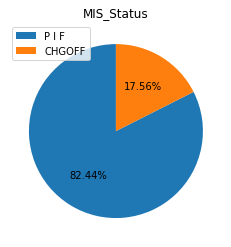

In [104]:
# Define target values for later transformation
LABELS = ['P I F', 'CHGOFF']
POSITIVE = LABELS[1]
NEGATIVE = LABELS[0]

counts = y_train.value_counts()
plt.pie(counts,
        startangle=90,
        autopct='%.2f%%')

plt.title('MIS_Status')
plt.legend(counts.index)
plt.show()

## Biến giải thích

Cùng xem qua dữ liệu:

In [10]:
print('DataFrame head:')
display(x_train.head())
print()

print('Columns details:')
display(get_df_info(x_train))

DataFrame head:


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
192615,2362105004,NORM'S TRUCKING,LACONIA,NH,3246,CITIZENS BANK NATL ASSOC,RI,484121,29-Mar-07,2007,...,1,N,N,14-May-10,30-Apr-07,"$14,000.00",$0.00,"$13,060.00","$14,000.00","$7,000.00"
610721,6068553004,A TO Z AUTOMOTIVE,WEST SENECA,NY,14227,KEYBANK NATIONAL ASSOCIATION,NY,811113,22-Nov-93,1994,...,0,N,N,NaN,30-Apr-94,"$47,600.00",$0.00,$0.00,"$47,600.00","$42,840.00"
251037,2765544005,ARPI SERVICE,NORTH HILLS,CA,91343,FIRST PRIVATE BANK & TRUST,CA,811412,5-Feb-99,1999,...,0,0,Y,NaN,31-Jan-00,"$50,000.00",$0.00,$0.00,"$50,000.00","$40,000.00"
371681,3601755003,"Albany Aqua Ducks, Inc.",ALBANY,NY,12201,KEYBANK NATIONAL ASSOCIATION,OH,487210,28-Aug-09,2009,...,1,N,N,NaN,1-Sep-09,"$35,000.00",$0.00,$0.00,"$35,000.00","$35,000.00"
841893,9024854009,JEFFREY D JOHN & COMPANY AN AC,SELMA,CA,93662,MUFG UNION BANK NATL ASSOC,CA,541211,4-Aug-05,2005,...,1,Y,N,NaN,31-Aug-05,"$15,456.00",$0.00,$0.00,"$10,000.00","$5,000.00"



Columns details:


,Column,Count,Null count,Num unique,Type
0,LoanNr_ChkDgt,807450,0,807450,int64
1,Name,807437,13,707545,object
2,City,807422,28,31266,object
3,State,807437,13,51,object
4,Zip,807450,0,32747,int64
5,Bank,806082,1368,5697,object
6,BankState,806075,1375,56,object
7,NAICS,807450,0,1306,int64
8,ApprovalDate,807450,0,9740,object
9,ApprovalFY,807450,0,65,object


### DisbursementGross, GrAppv, SBA_Appv (số tiền giải ngân, số tiền phê duyệt, số tiền SBA bảo lãnh)

* Dữ liệu dưới dạng chuỗi (ví dụ: $10,000.00) cần được chuyển thành float.
* Các phân phối đều lệch phải. Thực hiện biến đổi Box-Cox, qua biểu đồ trực quan hoá có thể thấy các khoản vay PIF có số tiền lớn hơn khoản vay CHGOFF.
* Nhìn biểu đồ phân tán có thể thấy 3 biến này có quan hệ tuyến tính rõ với nhau. Do đó ta chỉ chọn 1 trong 3 biến để đưa vào huấn luyện.

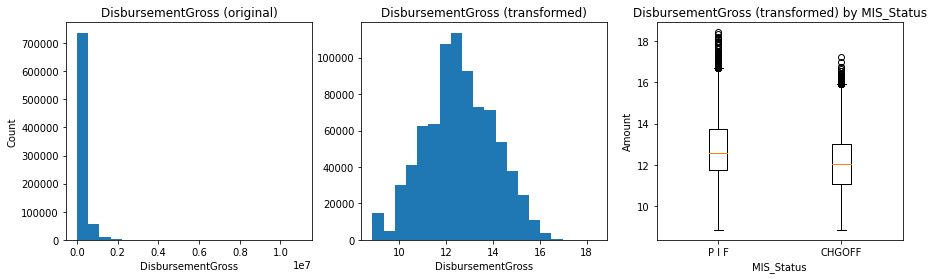

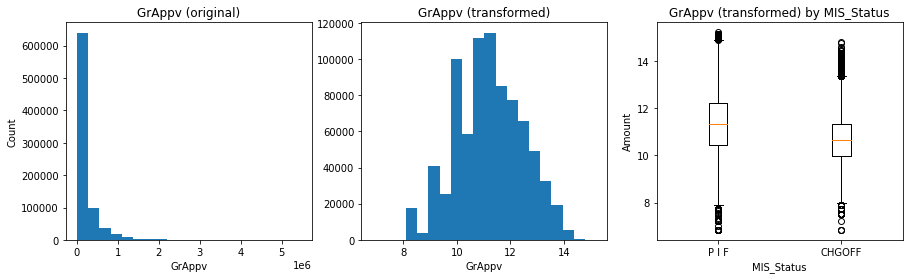

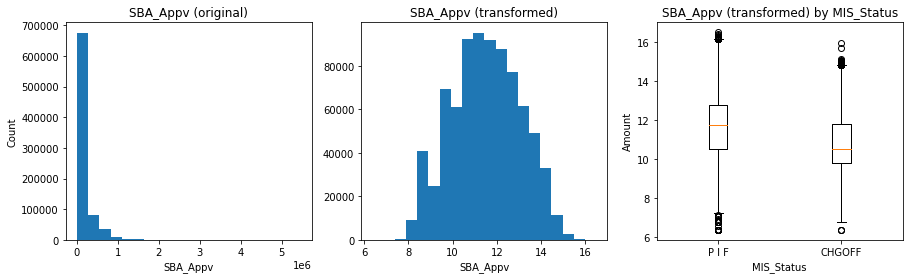

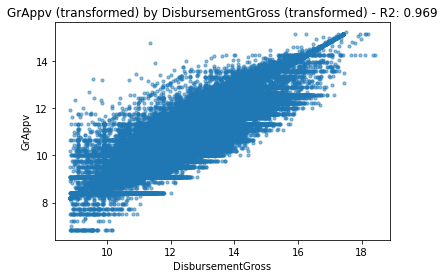

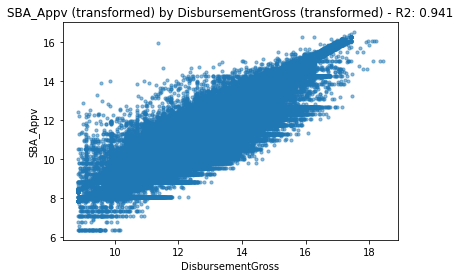

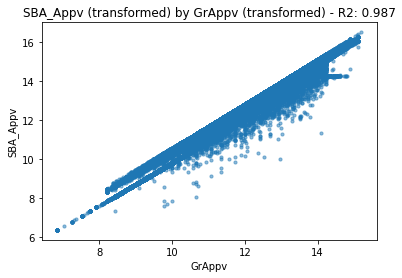

In [55]:
cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']

amounts = amount_value(x_train[cols])
box_cox = PowerTransformer(method='box-cox', standardize=False)
transformed_amounts = pd.DataFrame(box_cox.fit_transform(amounts),
                                   index=amounts.index,
                                   columns=cols)

for col in cols:
    plot_hist_and_boxplot(amounts[col],
                          transformed_amounts[col],
                          y_train,
                          LABELS)
plt.show()

pairs = [('DisbursementGross', 'GrAppv'),
         ('DisbursementGross', 'SBA_Appv'),
         ('GrAppv', 'SBA_Appv')]

corr_mat = transformed_amounts.corr()

for f1, f2 in pairs:
    plt.scatter(transformed_amounts[f1],
                transformed_amounts[f2],
                s=10.0,
                alpha=0.5)
    plt.title(f'{f2} (transformed) by {f1} (transformed) - R2: {corr_mat.loc[f1, f2]:.3f}')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

### SBA_Appv_portion (tỷ lệ bảo lãnh của SBA)

Khi loại bỏ GrAppv và SBA_Appv và thay thế bằng tỷ lệ SBA_Appv / GrAppv thì biến mới này có khả năng giải thích kết quả CHGOFF / PIF. Lý lẽ là khi SBA đánh giá khoản vay có khả năng trả được nợ thì mới chấp nhận tỷ lệ bảo lãnh cao và ngược lại.

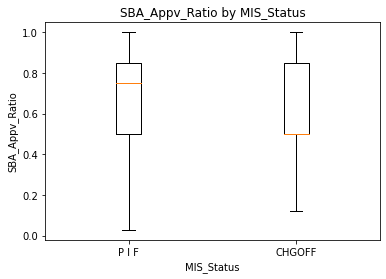

In [59]:
sba_ratio = amounts['SBA_Appv'] / amounts['GrAppv']
sba_ratio.name = 'SBA_Appv_Ratio'
plot_box(sba_ratio, y_train, LABELS)
plt.show()

### BalanceGross, ChgOffPrinGr (Dư nợ, Dư nợ không trả được)

* Với mục tiêu xác định có trả được nợ hay không chỉ cần căn cứ vào MIS_Status và có thể bỏ qua ChgOffPrinGr.
* Phần lớn BalanceGross bằng 0 do KH đã trả hết nợ hoặc chuyển thành nợ không trả được do đó cũng có thể bỏ qua.

In [60]:
print('BalanceGross counts:')
x_train['BalanceGross'].value_counts()

BalanceGross counts:


$0.00           807438
$96,908.00           1
$84,617.00           1
$43,127.00           1
$9,111.00            1
$12,750.00           1
$41,509.00           1
$37,100.00           1
$25,000.00           1
$996,262.00          1
$600.00              1
$827,875.00          1
$395,476.00          1
Name: BalanceGross, dtype: int64

### DisbursementDate (ngày giải ngân)

* Dataset bao gồm dữ liệu giải ngân từ 1987 đến năm 2014. Định dạng dưới dạng chuỗi (ví dụ 3-Jun-89) cần được chuyển đổi thành datetime.
* Có một số ngày giải ngân trước 1987 và sau 2014. Do số lượng là ít so với số lượng quan sát nên ta có thể bỏ qua không cần làm sạch.
* Có gần 2.000 trường hợp thiếu dữ liệu trước khi huấn luyện có thể sử dụng ngày phê duyệt (ApprovalDate) để thay thế.

In [61]:
disburse_dates = date_value(x_train[['DisbursementDate']], max_year=2020)
disburse_dates = disburse_dates['DisbursementDate']
print('Converted DisbursementDate:')
disburse_dates.dropna().sort_values()

Converted DisbursementDate:


54648    1948-09-17
49244    1966-08-16
697801   1968-03-19
732056   1968-11-22
726149   1969-05-22
            ...    
669507   2014-06-30
498326   2014-07-05
402166   2014-07-30
709337   2014-12-31
379815   2020-04-14
Name: DisbursementDate, Length: 805472, dtype: datetime64[ns]

### Term (kỳ hạn)

Kỳ hạn vay không bị thiếu dữ liệu. Tuy nhiên có khoảng 700 trường hợp có kỳ hạn bằng 0. Trong đó đa số trường hợp trước khi huấn luyện có thể sử dụng ngày Charged off để tính (kỳ hạn = ngày charged off - ngày giải ngân). Các trường hợp còn lại: gán giá trị mode.

In [70]:
print('Zero Term counts:')
display((x_train['Term']==0).value_counts())

print()
print('Term mode: %d months' % x_train['Term'].mode()[0])

Zero Term counts:


False    806727
True        723
Name: Term, dtype: int64


Term mode: 84 months


### Recession (suy thoái kinh tế)

* Các khoản vay có trải qua giai đoạn suy thoái kinh tế (tháng 12/2007 đến tháng 6/2009) có tỷ lệ CHGOFF cao hơn các giai đoạn khác. Đây là biến được tạo ra để đưa vào huấn luyện (https://en.wikipedia.org/wiki/Great_Recession)
* Điều kiện xác định khoản vay trải qua giai đoạn suy thoái kinh tế:
    + Ngày hết hạn từ 01/12/2007
    + Ngày hết hạn đến 30/06/2009
    + Trong đó Ngày hết hạn = ngày bắt đầu + kỳ hạn
* Đối với các khoản vay thiếu ngày giải ngân, gán ngày hết hạn bằng ngày charged off

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


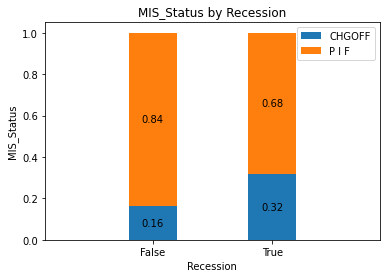

In [76]:
recession = mature_between(disburse_dates,
                           x_train['Term'],
                           '2007-12-01',
                           '2009-06-30')
recession.name = 'Recession'

counts = x_train.pivot_table(index=y_train,
                             columns=recession,
                             values='LoanNr_ChkDgt',
                             aggfunc='count')

portions = counts / counts.sum()
plot_stacked_bars(portions)

### City, State, Zip (thành phố, bang, zip code)

* Số bang = 51 có vẻ là giá trị đúng (50 bang + Washington DC), số thành phố, Zip code có hơn 30.000 quan sát.
* Với 13 trường hợp thiếu dữ liệu có thể suy luận từ mã Zip
* Các biến này đều thể hiện địa điểm của Khách hàng. Để giảm số lượng nhóm ta sẽ chọn bang (State) để đưa vào huấn luyện.
* Luận điểm ở đây: Mỗi bang ở nước Mỹ có 1 hệ thống pháp luật, môi trường kinh doanh, cơ cấu kinh tế khác nhau do đó có thể có tỷ lệ CHGOFF khác nhau. Ta có thể kiểm chứng qua việc vẽ biểu đồ trực quan hoá.
* Biến đưa vào huấn luyện:
    1. Bằng cách sử dụng phân cụm KMeans ta có thể chia các bang thành 5 nhóm (rất thấp, thấp, trung bình, cao, rất cao) theo tỷ lệ CHGOFF trong giai đoạn KHÔNG suy thoái. Đây là mức cơ sở ảnh hưởng tới kết quả đầu ra khi chưa tính tới yếu tố suy thoái.
    2. Vì phần lớn các bang đều có tỷ lệ CHGOFF tăng trong thời kỳ suy thoái. Tuy nhiên mức độ tăng là khác nhau giữa các bang (Như các bang CO, OR, OH tăng mạnh). Do đó ta có thể đưa vào mô hình thêm thuộc tính: tỷ lệ CHGOFF tăng trong giai đoạn suy thoái (rất thấp, thấp, trung bình, cao, rất cao). Việc chia nhóm cũng được thực hiện bằng phân cụm Kmeans. Sau khi mã hoá one-hot, các cột này sẽ được nhân với biến suy thoái (Recession) vì vậy khi khoản vay không trong giai đoạn suy thoái thì giá trị các cột này sẽ bằng 0.

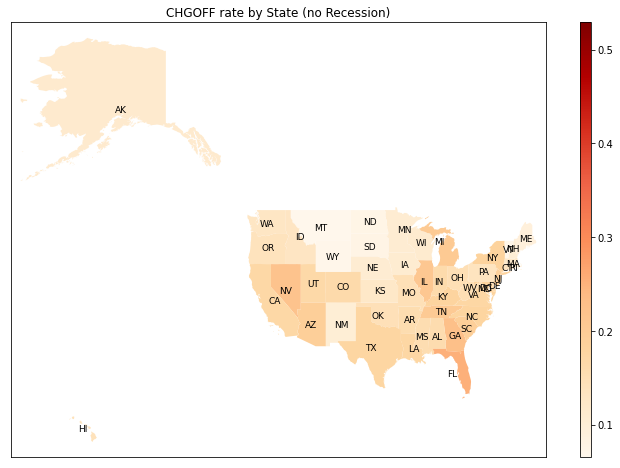

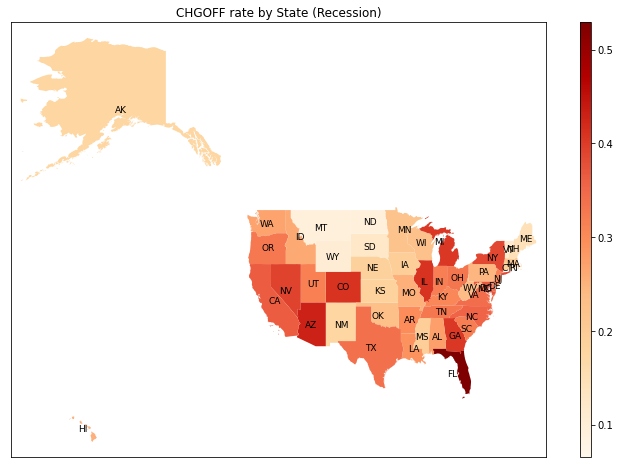

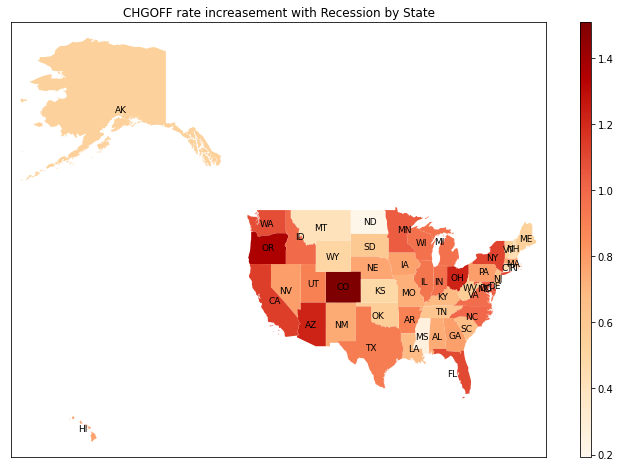

State clusters:
{0: {'CHGOFF': 0.07746100053792361, 'State': ['MT', 'ND', 'SD', 'VT', 'WY']}, 1: {'CHGOFF': 0.1248688352570829, 'State': ['AK', 'IA', 'KS', 'MA', 'ME', 'MN', 'NE', 'NH', 'NM', 'RI', 'WI']}, 2: {'CHGOFF': 0.15802924889961664, 'State': ['AL', 'AR', 'CT', 'HI', 'ID', 'MO', 'MS', 'OH', 'OK', 'OR', 'PA', 'WA', 'WV']}, 3: {'CHGOFF': 0.19354183590576768, 'State': ['AZ', 'CA', 'CO', 'DE', 'IN', 'KY', 'LA', 'MD', 'NC', 'NJ', 'NY', 'SC', 'TX', 'UT', 'VA']}, 4: {'CHGOFF': 0.2520986204872322, 'State': ['DC', 'FL', 'GA', 'IL', 'MI', 'NV', 'TN']}}

State clusters by CHGOFF rate increase:
{0: {'CHGOFF': 0.2540111432281849, 'State': ['MS', 'ND', 'RI']}, 1: {'CHGOFF': 0.6113224237063247, 'State': ['AK', 'CT', 'KS', 'ME', 'MT', 'NH', 'OK', 'SD', 'TN', 'VT', 'WV', 'WY']}, 2: {'CHGOFF': 0.788862959645203, 'State': ['AL', 'GA', 'HI', 'IA', 'KY', 'LA', 'MA', 'MO', 'NE', 'NJ', 'NM', 'NV', 'PA', 'SC']}, 3: {'CHGOFF': 1.133779313478206, 'State': ['AR', 'CA', 'DE', 'FL', 'ID', 'IL', 'IN', 'MD', 

In [146]:
def plot_states_data(feature):
    state_rate = target_rate_by_feature(x_train.loc[~recession, feature],
                                        y_train[~recession])
    state_rate = state_rate[POSITIVE]
    state_recession_rate = target_rate_by_feature(x_train.loc[recession, feature],
                                                  y_train[recession])
    state_recession_rate = state_recession_rate[POSITIVE]

    # Note same scale
    vmin = min(state_rate.min(), state_recession_rate.min())
    vmax = max(state_rate.max(), state_recession_rate.max())

    plot_geospartial(state_rate,
                     (12, 8),
                     cmap='OrRd',
                     title=f'{POSITIVE} rate by {feature} (no Recession)',
                     vmin=vmin,
                     vmax=vmax)

    plot_geospartial(state_recession_rate,
                     (12, 8),
                     cmap='OrRd',
                     title=f'{POSITIVE} rate by {feature} (Recession)',
                     vmin=vmin,
                     vmax=vmax)

    state_increase = (state_recession_rate - state_rate) / state_rate
    state_increase = state_increase.fillna(0)
    plot_geospartial(state_increase,
                     (12, 8),
                     cmap='OrRd',
                     title=f'{POSITIVE} rate increasement with Recession by {feature}')

    plt.show()
    return state_rate, state_recession_rate, state_increase

state_rate, _, state_increase = plot_states_data('State')

# Finding how to group States
model = KMeans(n_clusters=5)
STATE_CLUSTERS = find_clusters(model, state_rate)
print('State clusters:')
print(state_clusters)
print()
STATE_INCREASE_CLUSTER = find_clusters(model, state_increase)
print(f'State clusters by {POSITIVE} rate increase:')
print(state_increase_clusters)

### Bank, BankState (ngân hàng, bang của ngân hàng)

* Có 56 kiểu giá trị do tại cột này liệt kê cả các lãnh thổ không phải là bang như: Guam, Puerto Rico, Vigin Island...
* Tỷ lệ CHGOFF giữa các BankState cũng có sự khác biệt
* Thực hiện feature engineering như biến State
* Các trường hợp thiếu dữ liệu có thể gán bằng State

BankState territories: {'PR', 'EN', 'AN', 'VI', 'GU'}


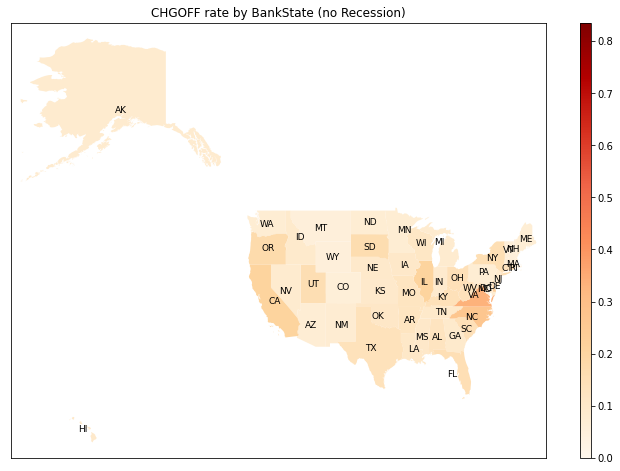

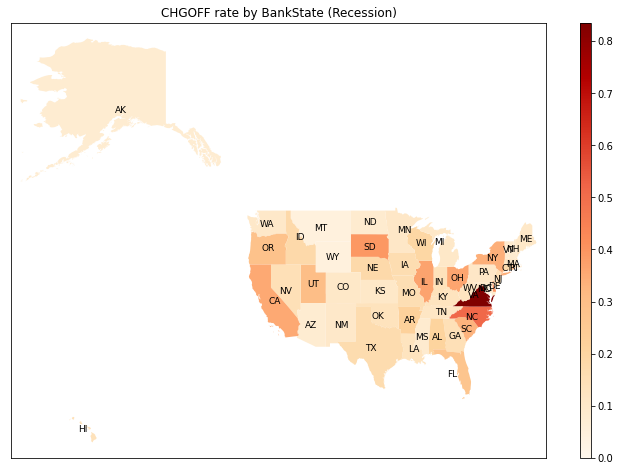

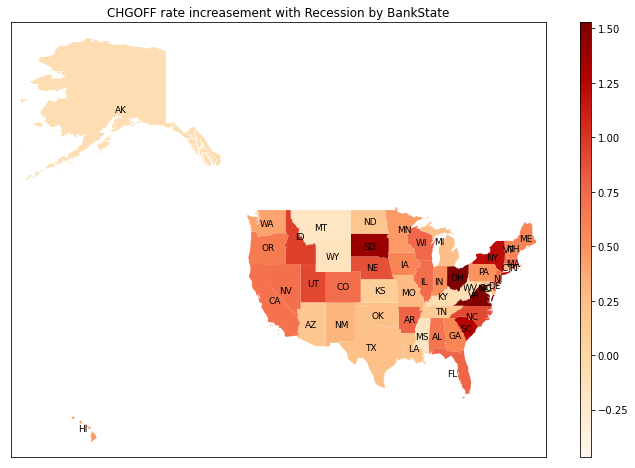

BankState clusters:
{0: {'CHGOFF': 0.07746100053792361, 'State': ['MT', 'ND', 'SD', 'VT', 'WY']}, 1: {'CHGOFF': 0.1248688352570829, 'State': ['AK', 'IA', 'KS', 'MA', 'ME', 'MN', 'NE', 'NH', 'NM', 'RI', 'WI']}, 2: {'CHGOFF': 0.15802924889961664, 'State': ['AL', 'AR', 'CT', 'HI', 'ID', 'MO', 'MS', 'OH', 'OK', 'OR', 'PA', 'WA', 'WV']}, 3: {'CHGOFF': 0.19354183590576768, 'State': ['AZ', 'CA', 'CO', 'DE', 'IN', 'KY', 'LA', 'MD', 'NC', 'NJ', 'NY', 'SC', 'TX', 'UT', 'VA']}, 4: {'CHGOFF': 0.2520986204872322, 'State': ['DC', 'FL', 'GA', 'IL', 'MI', 'NV', 'TN']}}

BankState clusters by CHGOFF rate increase:
{0: {'CHGOFF': 0.2540111432281849, 'State': ['MS', 'ND', 'RI']}, 1: {'CHGOFF': 0.6113224237063247, 'State': ['AK', 'CT', 'KS', 'ME', 'MT', 'NH', 'OK', 'SD', 'TN', 'VT', 'WV', 'WY']}, 2: {'CHGOFF': 0.788862959645203, 'State': ['AL', 'GA', 'HI', 'IA', 'KY', 'LA', 'MA', 'MO', 'NE', 'NJ', 'NM', 'NV', 'PA', 'SC']}, 3: {'CHGOFF': 1.133779313478206, 'State': ['AR', 'CA', 'DE', 'FL', 'ID', 'IL', 'IN'

In [147]:
territories = set(x_train['BankState'].unique()) - set(x_train['State'].unique())
print('BankState territories:', territories)

state_rate, _, state_increase = plot_states_data('BankState')

BANK_STATE_CLUSTERS = find_clusters(model, state_rate)
print('BankState clusters:')
print(state_clusters)
print()
BANKSTATE_INCREASE_CLUSTER = find_clusters(model, state_increase)
print(f'BankState clusters by {POSITIVE} rate increase:')
print(state_increase_clusters)

### NAICS (mã ngành)

* Có hơn 180.000 trường hợp thiếu dữ liệu mã ngành (=0).
* 2 ký tự đầu cột này được code từ 11 - 92 cho mỗi ngành/ nhóm ngành, tổng cộng 24 loại theo bảng tham số naics.csv.
* Các ngành khác nhau có mức độ rủi ro khác nhau có tỷ lệ CHGOFF sẽ khác nhau.
* Bằng cách sử dụng phân cụm KMeans ta có thể chia các ngành thành 5 nhóm (rất thấp, thấp, trung bình, cao, rất cao) theo tỷ lệ CHGOFF trong giai đoạn không suy thoái.
* Hầu hết các ngành đều có tỷ lệ CHGOFF tăng trong thời kỳ suy thoái. Tuy nhiên mức độ tăng là khác nhau giữa các ngành (Public Administration có tỷ lệ CGH. Do đó ta có thể đưa vào mô hình thêm thuộc tính: tỷ lệ CHGOFF tăng trong giai đoạn suy thoái (thấp, trung bình, cao). Việc chia nhóm cũng được thực hiện bằng phân cụm Kmeans.


In [148]:
naics_dict = pd.read_csv('data/naics.csv', index_col=0).to_dict()['Description']
print('NAICS Codes:')
naics_dict

NAICS Codes:


{11: 'Agriculture, forestry, fishing and hunting',
 21: 'Mining, quarrying, and oil and gas extraction',
 22: 'Utilities',
 23: 'Construction',
 31: 'Manufacturing',
 32: 'Manufacturing',
 33: 'Manufacturing',
 42: 'Wholesale trade',
 44: 'Retail trade',
 45: 'Retail trade',
 48: 'Transportation and warehousing',
 49: 'Transportation and warehousing',
 51: 'Information',
 52: 'Finance and insurance',
 53: 'Real estate and rental and leasing',
 54: 'Professional, scientific, and technical services',
 55: 'Management of companies and enterprises',
 56: 'Administrative and support and waste management and remediation services',
 61: 'Educational services',
 62: 'Health care and social assistance',
 71: 'Arts, entertainment, and recreation',
 72: 'Accommodation and food services',
 81: 'Other services (except public administration)',
 92: 'Public administration'}

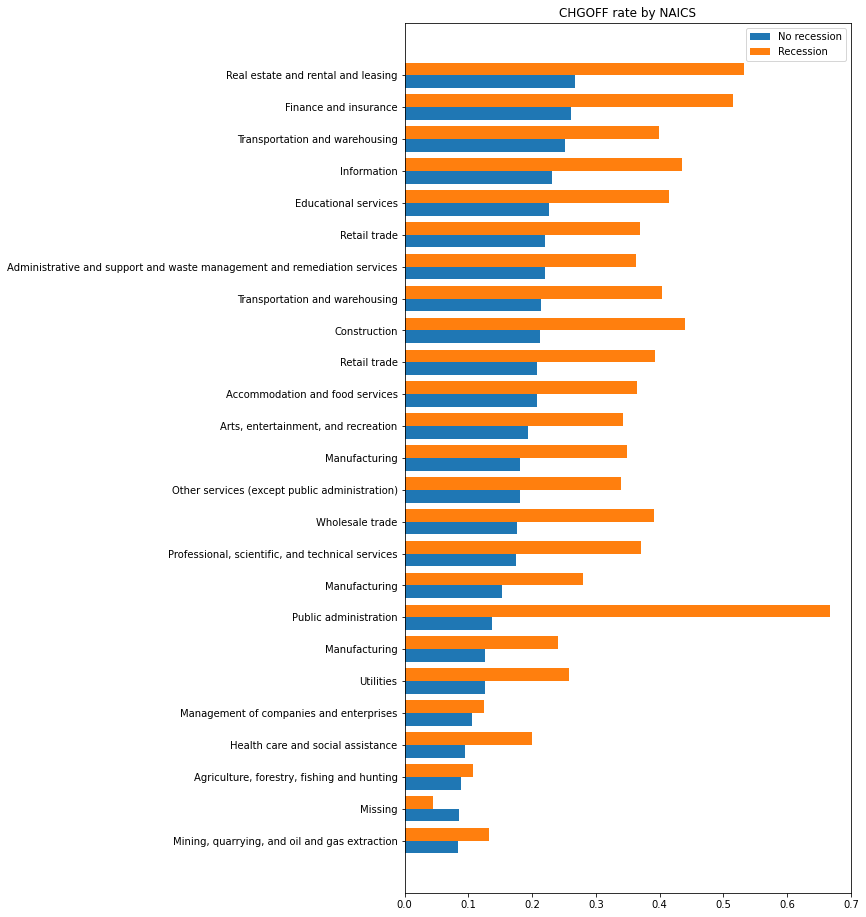

In [149]:
def transform(x):
    return int(str(x)[:2])
    
naics_no_recession = chgoff_rate_by_feature(x_train.loc[~recession, 'NAICS'].map(transform),
                                            y_train[~recession])
naics_recession = chgoff_rate_by_feature(x_train.loc[recession, 'NAICS'].map(transform),
                                         y_train[recession])

naics_df = pd.concat([naics_no_recession,
                      naics_recession],
                     axis='columns')
naics_df.index = naics_df.index.map(naics_dict).fillna('Missing')
naics_df.columns = ['No recession', 'Recession']
naics_df = naics_df.sort_values('No recession')
y = np.arange(naics_df.shape[0])
plt.figure(figsize=(8, 16))
plt.barh(y - 0.2, naics_df['No recession'], height=0.4)
plt.barh(y + 0.2, naics_df['Recession'], height=0.4)
plt.yticks(y, naics_df.index)
plt.title('CHGOFF rate by NAICS')
plt.legend(['No recession', 'Recession'])
plt.show()

In [ ]:
model = KMeans(n_clusters=5)
naics_clusters = find_clusters(model, naics_no_recession, 'NAICS')
print('NAICS clusters:')
print(naics_clusters)
print()
model = KMeans(n_clusters=3)
naics_recession_increase = (naics_recession - naics_no_recession) / naics_no_recession
naics_increase_clusters = find_clusters(model, naics_recession_increase, 'NAICS')
print('NAICS clusters by recession increase:')
print(naics_increase_clusters)

### NewExist (Khách hàng là doanh nghiệp mới)

* Định nghĩa Khách hàng mới:
    * Khách hàng thành lập trên 2 năm: Giá trị 1
    * Khách hàng thành lập từ 2 năm trở xuống: Giá trị 2
    * Thiếu dữ liệu: Giá trị 0
* Qua quan sát biểu đồ thì biến này không có ảnh hưởng nhiều tới kết quả.
* Có khoảng 900 trường hợp thiếu dữ liệu có thể gán bằng 1 (giá trị mode)

In [ ]:
print('NewExist counts:')
x_train['NewExist'].value_counts()

In [ ]:
new_exist = x_train['NewExist']
counts = pd.DataFrame(y_train[~recession]).pivot_table(index=y_train[~recession],
                                                       columns=new_exist[~recession],
                                                       values='MIS_Status',
                                                       aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.title('MIS_Status by NewExit (no Recession)')
plt.show()

counts = pd.DataFrame(y_train[recession]).pivot_table(index=y_train[recession],
                                                      columns=new_exist[recession],
                                                      values='MIS_Status',
                                                      aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.title('MIS_Status by NewExit (Recession)')
plt.show()

In [ ]:
x_train['NoEmp'].value_counts(dropna=False).sort_index()

In [ ]:
box_cox_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
no_emp = x_train['NoEmp']
cond = no_emp > 0
#cond[:] = True
no_emp = no_emp[cond]
no_emp_trans = pd.Series(
    box_cox_transformer.fit_transform(no_emp.to_numpy().reshape(-1, 1))[:, 0],
    index=no_emp.index
)

plot_hist_and_box_plot(no_emp,
                       no_emp_trans,
                       y_train[cond])

plt.show()